In [1]:
using Plots
using Combinatorics: multiset_combinations
using DataStructures
import Base.isless

# Optimal college application strategy

Alma's problem: $$\max\bigl\lbrace \operatorname{E}[\max\lbrace t_j Z_j: j \in \mathcal{X}\rbrace] : |\mathcal{X}| \leq h\bigr\rbrace$$

where $Z_j$ are independent Bernoulli with probabilities $f_j$. 

In [2]:
"""
    College(f, t, ft)

Contains a college's admissions probability `f`, utility value `t`,
and their product `ft`.
"""
struct College
    f::Float64
    t::Float64
    ft::Float64
    
    College(f::Float64, t::Float64) = new(f, t, f*t)
end

isless(c1::College, c2::College) = isless(c1.ft, c2.ft)

isless (generic function with 54 methods)

In [3]:
"""
    applicationorder(f, t, h=m)

Produce the optimal order of application for the market defined by admissions probabilities `f`
and utility values `t`. 
"""
function applicationorder(f::Vector{Float64}, t::Vector{Float64}, h=nothing::Union{Int64, Nothing})
    m = length(f)
    @assert m == length(t)
    @assert issorted(t)
    if isnothing(h)
        h = m
    else
        @assert 0 < h ≤ m
    end

    mkt = MutableBinaryMaxHeap{College}()
    for j in 1:m
        push!(mkt, College(f[j], t[j]))
    end

    onheap = trues(m)
    apporder = zeros(Int, h)
    v = zeros(h)
    for j in 1:h
        c_k, k = top_with_handle(mkt)
        v[j] = get(v, j-1, 0) + c_k.ft
        
        pop!(mkt)
        
        apporder[j] = k
        onheap[k] = false
        for i in 1:k-1
            onheap[i] && update!(mkt, i, College(mkt[i].f, mkt[i].t * (1 - c_k.f)))
        end
        for i in k+1:m
            onheap[i] && update!(mkt, i, College(mkt[i].f, mkt[i].t - c_k.ft))
        end
    end
    
    return apporder, v
end


"""
    valuation(X, f, t)

Returns the expected value of the portfolio `X`, a vector of school indices, on the
the market defined by admissions probabilities `f` and utility values `t`. 
"""
function valuation(X::Vector{Int64}, f, t)
    @assert issorted(t)
    sort!(X)
    h = length(X)
    
    if h > 1    
        res = 0.0
        cp = reverse(cumprod(1 .- reverse(f[X[2:end]])))
    
        for j in 1:h-1
            res += t[X[j]] * f[X[j]] * cp[j]
        end
        
        res += t[X[end]] * f[X[end]]
        
        return res
    else
        return f[X[1]] * t[X[1]]
    end
end


"""
    optimalportfolio_enumerate(h, f, t)

Produce the optimal portfolio of size `h` on the market defined by admissions probabilities `f`
and utility values `t`. Solves by enumeration. 
"""
function optimalportfolio_enumerate(h, f::Vector{Float64}, t::Vector{Float64})
    m = length(t)
    X = zeros(Int, h)
    v = 0.0
    
    for Y in multiset_combinations(1:m, h)
        if (w = valuation(Y, f, t)) > v
            v = w
            X[:] = Y
        end
    end
    
    return X
end

optimalportfolio_enumerate

In [4]:
function plotsmaker()
    m = length(t)
    
    pl = [plot(
            xlabel="f",
            ylabel="t",
            size=(700, 700)
            ) for i in 1:m+2]
    
    x = zeros(Bool, m, m)
    
    scatter!(pl[1], f, t, c=:darkslategray, ms=11, msw=0, msa=0, legend=nothing)
    
    for i in 1:m
        x[optimalportfolio_enumerate(i, f, t), i] .= true
        
        scatter!(pl[i+1], f[.!x[:, i]], t[.!x[:, i]], c=:darkslategray, ms=11, msw=0, msa=0, label=nothing)
        scatter!(pl[i+1], f[x[:, i]], t[x[:, i]], c=:orangered, ms=11, msw=0, msa=0, label="apply when h = $i")
    end
    
    apporder = sortperm(reshape(sum(x, dims=2), :), rev=true)
    
    scatter!(pl[end], f, t, c=:forestgreen, ms=13, msw=0, msa=0, legend=nothing)
    annotate!(pl[end], [(f[i], t[i], text("$(apporder[i])", 9, :white)) for i in 1:m])
    
    return pl, x, apporder
end

plotsmaker (generic function with 1 method)

Solve an instance by enumeration, check that the results agree with the fast algorithm, produce a series of plots showing the nestedness property.

In [25]:
m = 20

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))

@time pl, x, apporder = plotsmaker()
v_enum = [valuation(apporder[1:h], f, t) for h in 1:m]

for c in eachcol(x)
    println(c)
end

# for p in pl
#     display(p)
# end

[apporder v_enum applicationorder(f, t)...]

  3.206155 seconds (13.70 M allocations: 1.304 GiB, 8.90% gc time)
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Bool[0, 0, 0, 0, 1, 1, 

20×4 Matrix{Float64}:
 10.0  0.356129  10.0  0.356129
 20.0  0.537388  20.0  0.537388
 12.0  0.659722  12.0  0.659722
 13.0  0.724828  13.0  0.724828
 18.0  0.769901  18.0  0.769901
 15.0  0.803292  15.0  0.803292
 16.0  0.826043  16.0  0.826043
 17.0  0.843559  17.0  0.843559
 19.0  0.853105  19.0  0.853105
 14.0  0.860191  14.0  0.860191
  6.0  0.86477    6.0  0.86477
 11.0  0.867969  11.0  0.867969
  8.0  0.869721   8.0  0.869721
  9.0  0.870987   9.0  0.870987
  5.0  0.871616   5.0  0.871616
  7.0  0.871842   7.0  0.871842
  3.0  0.871914   3.0  0.871914
  4.0  0.871936   4.0  0.871936
  2.0  0.87194    2.0  0.87194
  1.0  0.87194    1.0  0.87194

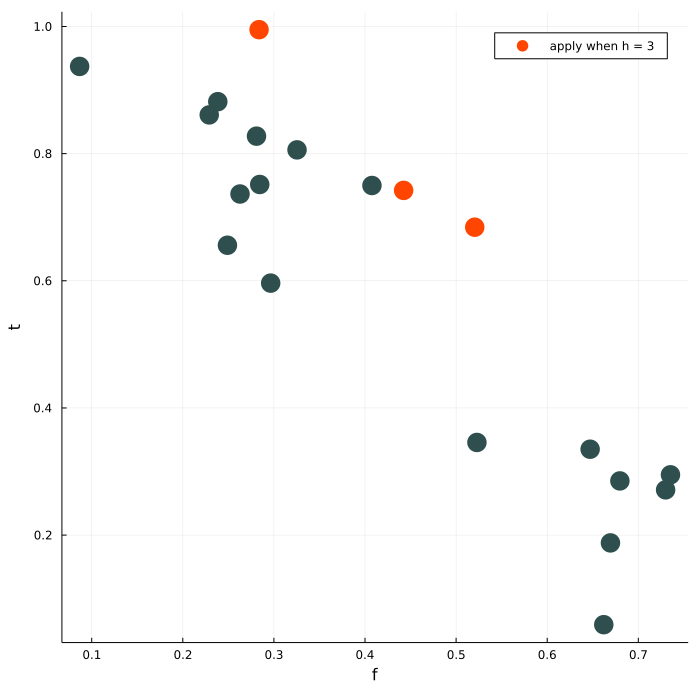

In [26]:
# for (n, i) in enumerate(pl)
#       display(i)
# end
display(pl[4])

In [47]:
for (n, i) in enumerate(pl)
    savefig(i, "optportfolio-$(n-1).png")
    savefig(i, "optportfolio-$(n-1).pdf")
end

In [33]:
for i in 0:length(pl)-1
    print("\\begin{frame}\\begin{center}\\includegraphics[height=\\textheight]{./plots/optportfolio-$i.pdf}\\end{center}\\end{frame}\n")
end

\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-0.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-1.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-2.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-3.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-4.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-5.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-6.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportfolio-7.pdf}\end{center}\end{frame}
\begin{frame}\begin{center}\includegraphics[height=\textheight]{./plots/optportf

## Example for which greedy algorithm is inoptimal

In [3]:
f = [0.4, 0.4, 0.3]
t = [0.7, 0.8, 0.9]

pl, x, apporder = plotsmaker()

so = sortperm(t .* f, rev=true)
for c in eachcol(x)
    println(c[so])
end

Bool[1, 0, 0]
Bool[1, 0, 1]
Bool[1, 1, 1]


In [311]:
[f t f .* t]

3×3 Matrix{Float64}:
 0.4  0.7  0.28
 0.4  0.8  0.32
 0.3  0.9  0.27

## Comparative statics example

In [21]:
t = Float64.(collect(range(start=200, step=50, length=8)))
f = [0.39, 0.33, 0.24, 0.24, 0.05, 0.03, 0.1, 0.12]

8-element Vector{Float64}:
 0.39
 0.33
 0.24
 0.24
 0.05
 0.03
 0.1
 0.12

In [22]:
apporder, v = applicationorder(f, t)
# v = [valuation(apporder[1:i], f, t) for i in 1:8]

[t f apporder round.(v)[apporder]]

8×4 Matrix{Float64}:
 200.0  0.39  4.0  230.0
 250.0  0.33  2.0  147.0
 300.0  0.24  8.0  294.0
 350.0  0.24  1.0   84.0
 400.0  0.05  7.0  289.0
 450.0  0.03  3.0  195.0
 500.0  0.1   5.0  258.0
 550.0  0.12  6.0  282.0

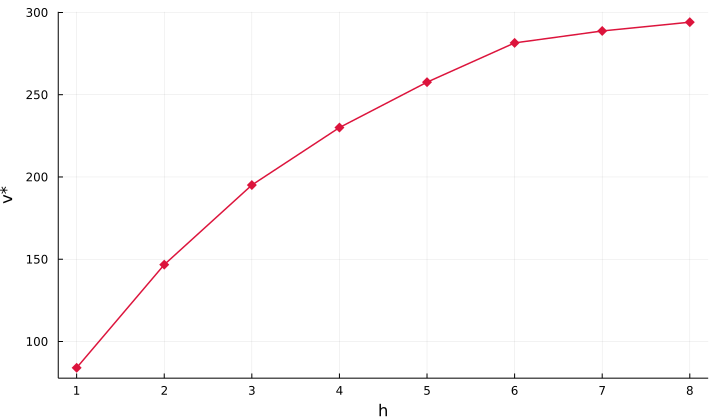

In [23]:
pl = plot(v, legend=false, size=(720, 420), xlabel="h", ylabel="v*", lw=1.5, color=:crimson, xticks=1:8, marker=:diamond, msw=0, msa=0, ms=5)

In [41]:
savefig(pl, "h-utility.png")
savefig(pl, "h-utility.pdf")

## Quasipolynomial-time algorithm for generalization with variable application costs

Ellis's problem: Now $g_j$ is the cost of applying to college $c_j$; $H$ is the total application budget. The problem is
$$\max\Bigl\lbrace \operatorname{E}[\max\lbrace t_j Z_j: j \in \mathcal{X}\rbrace] : \sum_{j \in \mathcal{X}} g_j \leq H\Bigr\rbrace$$

Let $V[j, h]$ denote the optimal portfolio costing no more than $h$ using only the first $j$ schools. 

Base cases:
$$
\begin{align*}
V[j, 0] &= 0, \quad & j = 0\dots m \\
V[0, h] &= -\infty, \quad & h < 0 \\
\end{align*}
$$

Bellman equation:
$$
\begin{align*}
V[j, h] &= \max\bigl( V[j-1, h],~(1 - f_j) V[j-1, h-g_j] + f_j t_j \bigr), \quad & j = 1\dots m, h = 1\dots H
\end{align*}
$$

In [5]:
function valuationtable(
        f::Vector{Float64},
        t::Vector{Float64},
        g::Vector{Int64},
        H=nothing::Union{Int64, Nothing})
    m = length(f)
    @assert m == length(t) == length(g)
    @assert issorted(t)
    if isnothing(H)
        H = sum(g)
    else
        @assert 0 < H
    end
    
    V = zeros(m, H)
#     U = falses(m, H)
    for j in 1:m, h in 1:H
        if h < g[j]
            V[j, h] = get(V, (j-1, h), 0)
        else
            V[j, h] = max(
                get(V, (j-1, h), 0),
                (1 - f[j])*get(V, (j-1, h - g[j]), 0) + f[j] * t[j]
            )
        end
    end
    
    h = H
    X = Int64[]
    for j in m:-1:1
        if get(V, (j-1, h), 0) <  get(V, (j, h), 0)
            push!(X, j)
            h -= g[j]
        end
    end

    return X, V
end


function optimalportfolio_varcosts_recursive(
        f::Vector{Float64},
        t::Vector{Float64},
        g::Vector{Int64},
        H=nothing::Union{Int64, Nothing},
        memoize=true)
    m = length(f)
    @assert m == length(t) == length(g)
    @assert issorted(t)
    if isnothing(H)
        H = sum(g)
    else
        @assert 0 < H
    end
    
    if memoize
        V_dict = Dict{Tuple{Int64, Int64}, Float64}()
    end
    
    function V(j, h)
        if memoize && haskey(V_dict, (j, h))
            return V_dict[(j, h)]
        end
        
        if j == 0 || h == 0
            return 0.0
        elseif h < g[j]
            if memoize
                push!(V_dict, (j, h)=>V(j-1, h))
                return V_dict[(j, h)]
            else
                return V(j-1, h)
            end
        else
            if memoize
                push!(V_dict, (j, h)=>max(
                    V(j-1, h),
                    (1 - f[j]) * V(j-1, h - g[j]) + f[j] * t[j]
                ))
                return V_dict[(j, h)]
            else
                return max(
                    V(j-1, h),
                    (1 - f[j]) * V(j-1, h - g[j]) + f[j] * t[j]
                )
            end
        end
    end
    
    h = H
    X = Int64[]
    
    if memoize
        v = V(m, H)
    end
        
    for j in m:-1:1
        if V(j-1, h) < V(j, h)
            push!(X, j)
            h -= g[j]
        end
    end
    
    if memoize
        return X, v
    else
        return X, valuation(X, f, t)
    end
end

optimalportfolio_varcosts_recursive (generic function with 3 methods)

Solve an instance with all $g_j = 1$ and make sure it agrees with solution from above.

In [6]:
m = 10

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
g = ones(Int64, m)
h = m ÷ 2

X, V = valuationtable(f, t, g, h)
sort!(X)
X_, v_ = optimalportfolio_varcosts_recursive(f, t, g, h)
sort!(X_)
X__, V__ = applicationorder(f, t, h)
sort!(X__)
display([X X_ X__])
V[end, end], v_, V__[h]

5×3 Matrix{Int64}:
  6   6   6
  7   7   7
  8   8   8
  9   9   9
 10  10  10

(0.7224205867832922, 0.7224205867832922, 0.7224205867832922)

Make sure the table form and recursive form agree with each other.

In [7]:
m = 10

φ = 0.7
t = rand(m) |> sort
f = 1 .- (φ*t + (1-φ)*rand(m))
g = rand(1:5, m)
H = sum(g) ÷ 3

@show g
@show H

X, V = valuationtable(f, t, g, H)
display(V)
sort!(X)

X_, v_ = optimalportfolio_varcosts_recursive(f, t, g, H, true)
sort!(X_)
display([X g[X] X_ g[X_]])

@show V[end, end], v_

10×10 Matrix{Float64}:
 0.0       0.0       0.0       0.0       …  0.135877  0.135877  0.135877
 0.0       0.1604    0.1604    0.1604       0.1816    0.1816    0.1816
 0.0       0.1604    0.182886  0.182886     0.251901  0.251901  0.261023
 0.177317  0.177317  0.260453  0.272107     0.307878  0.307878  0.307878
 0.177317  0.177317  0.260453  0.272107     0.357012  0.357012  0.379856
 0.177317  0.32009   0.411142  0.411142  …  0.478186  0.499594  0.503416
 0.177317  0.32009   0.411142  0.411142     0.519003  0.519003  0.545844
 0.177317  0.32009   0.411142  0.411142     0.519003  0.519003  0.545844
 0.314754  0.42391   0.5118    0.567852     0.60552   0.634251  0.634251
 0.314754  0.42391   0.5118    0.567852     0.667107  0.686277  0.688964

5×4 Matrix{Int64}:
  3  3   3  3
  4  1   4  1
  6  2   6  2
  9  1   9  1
 10  3  10  3

g = [5, 2, 3, 1, 4, 2, 5, 5, 1, 3]
H = 10
(V[end, end], v_) = (0.6889641367029831, 0.6889641367029831)


(0.6889641367029831, 0.6889641367029831)

## Sandbox

Search for a tight example for bound $v(\mathcal{Y}) \geq v(\mathcal{X}) /h$, where $\mathcal{Y}$ is the naive solution.

[1.0, 1.998046875, 2.9921951293945312, 3.9785766005516052, 4.94954586122185, 5.8901723324961495, 6.772009649315805, 7.543617301533004, 8.122323040695903, 8.411675910277353]


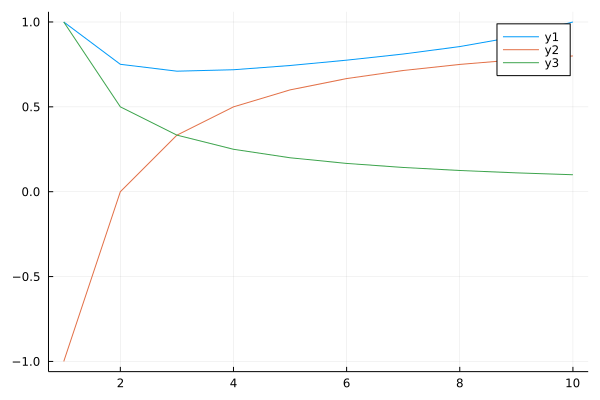

In [9]:
m = 10
h = 10

f = 2.0 .^ range(0, step=-1, length=m)
t = 1 ./ f # (1 .+ range(0.000001, 0, length=m)) ./ f
ft = f .* t

X, V = applicationorder(f, t, h)
println(V)
[valuation(collect(1:j), f, t)/V[j] for j in 1:h] |> plot
plot!([(j-2)/(j) for j in 1:h])
plot!([1/j for j in 1:h])

[1, 1000, 999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952]
[1.0, 1.999, 2.997, 3.9939999999999998, 4.99, 5.985, 6.979, 7.9719999999999995, 8.963999999999999, 9.954999999999998, 10.944999999999999, 11.934, 12.921999999999999, 13.908999999999999, 14.895, 15.879999999999999, 16.864, 17.847, 18.829, 19.810000000000002, 20.790000000000003, 21.769000000000002, 22.747000000000003, 23.724000000000004, 24.700000000000003, 25.675000000000004, 26.649000000000004, 27.622000000000003, 28.594000000000005, 29.565000000000005, 30.535000000000004, 31.504000000000005, 32.47200000000001, 33.43900000000001, 34.40500000000001, 35.37000000000001, 36.33400000000001, 37.29700000000001, 38.259000000000015, 39.22000000000001, 40.180000000000014, 41.13900000000002, 42.097000000000016, 43.054000000000016, 44.01000000000002, 4

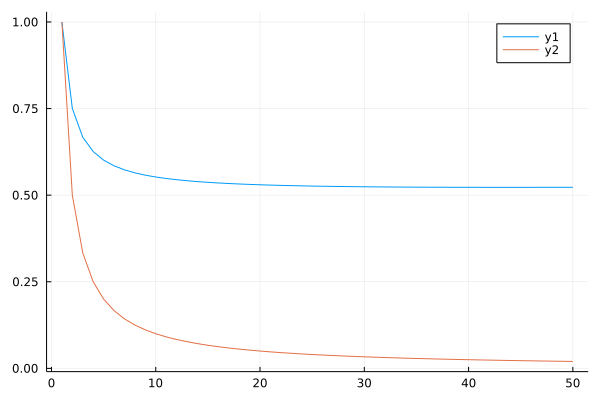

In [45]:
m = 1000
h = 50

f = 1 ./ (1:m)
t = 1 ./ f .^ 1 # (1 .+ range(0.000001, 0, length=m)) ./ f
ft = f .* t

X, V = applicationorder(f, t, h)
println(X)
println(V)
[valuation(collect(1:j), f, t)/V[j] for j in 1:h] |> plot
plot!([1/j for j in 1:h])

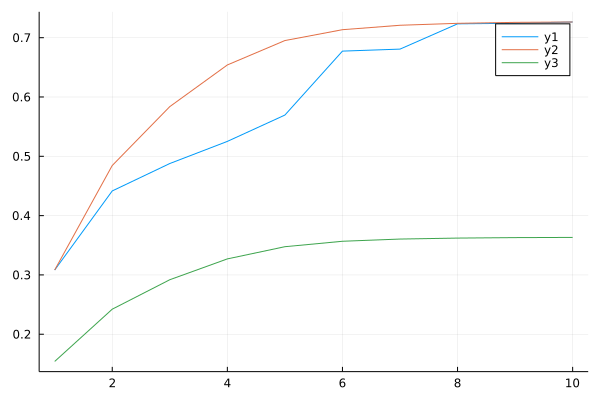

In [57]:
m = 10

φ = 0.7
# t = rand(m) |> sort
# f = 1 .- (φ*t + (1-φ)*rand(m))

ft = f .* t
T = sortperm(ft, rev=true)
vT = [valuation(T[1:h], f, t) for h in 1:m]
plot(vT)


X, V = applicationorder(f, t, m)
plot!(V)
plot!(0.5V)

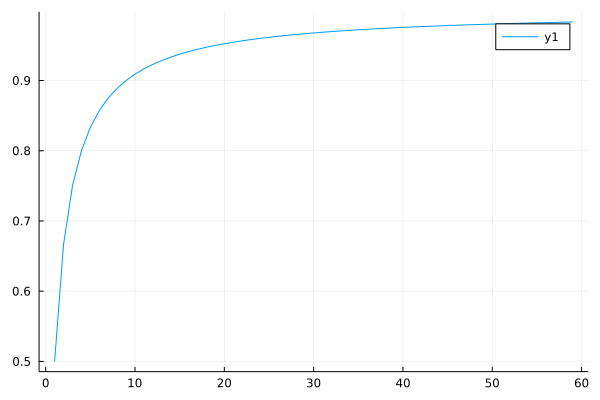

In [60]:
plot([(h-1)/h for h in 2:60])